In [5]:
"""
    This module is used to extract data from pdf files.
    Given search fields with bounding box ( x, y, w, h) co-ordinates for text and 
    page no this module can extract value at given location.
"""
import copy
import re
from re import sub
import os
import glob
from subprocess import run
import logging
from pdftabextract.common import read_xml, parse_pages
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering, KMeans
import sys

%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm
import random


logger = logging.getLogger(__name__)

OUTPUT_DIR = 'temp'

"""
    Feature Extraction Helpers
"""
def semicolon_index(text):
    return text.find(':')

def space_count(text):
    return text.count(' ')

def alphabet_count(text):
    return len(re.findall('[A-Za-z]', text))

def digit_count(text):
    return len(re.findall('[0-9]', text))

random.seed(90000)
def get_spaced_colors(number_of_colors):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]
    return color
color_map = get_spaced_colors(100000)

    
failed_counter = 0
success_counter = 0

In [16]:
def get_search_fields(extract_config):
    """
        This method takes local path to the pdf file and list of search fields to be extracted from pdf file.
        Returns the extracted values for search fields.
    """
    try:
        pdf_file_path = extract_config['sample_file_name']
        
        # Extract the name pdf file from file_path
        pdf_file_name = os.path.basename(pdf_file_path)
        logger.debug('pdf_file_name : {}'.format(pdf_file_name))
        
        
        # Create temporary output directory
        output_directory_name = os.path.splitext(pdf_file_name)[0]
        logger.debug('output_directory_name : {}'.format(output_directory_name))
        
        output_path = os.path.join(OUTPUT_DIR, output_directory_name)
        logger.debug('output_path : {}'.format(output_path))
        
        os.makedirs(output_path, exist_ok=True)
        
        # Export file paths
        output_xml_file_path = os.path.join(output_path, pdf_file_name+'.xml')
        output_txt_file_path = os.path.join(output_path, pdf_file_name+'.txt')
        output_image_file_path = os.path.join(output_path, pdf_file_name+'')

        
        logger.debug('output_xml_file_path : {}'.format(output_xml_file_path))
        logger.debug('output_txt_file_path : {}'.format(output_txt_file_path))
        
        # Convert PDF to HTML using poppler
        run(['pdftohtml', pdf_file_path, '-c', '-hidden', '-xml', '-s', '-nomerge', output_xml_file_path])

        # Convert PDF to Text using poppler
        run(['pdftotext', pdf_file_path, output_txt_file_path])
        
        # Convert PDF to Image using poppler
        run(['pdftoppm', '-rx', '300', '-ry', '300', '-tiff', pdf_file_path, output_image_file_path])
        
        
        # Initialize text_boxes
        text_boxes = []

        # Load the XML that was generated by pdftohtml
        xmltree, xmlroot = read_xml(output_xml_file_path)

        # parse it and generate a dict of pages
        pages = parse_pages(xmlroot)
        
        logger.debug('number of page : {}'.format(len(pages)))
        
        # Extract features from text boxes in each pages
        for page_no, page in pages.items():

            logger.debug('processing page : {} of {}'.format(page_no, len(pages)))
            
            width = page['width']
            height = page['height']
            
            logger.debug("page({}) {}x{}".format(page_no, width, height))
            
            logger.debug('number of text_boxes : {}'.format(len(page['texts'])))
    
            for text in page['texts']:

                text_content = text['value']
            
                f_length = max(1,len(text_content))
                f_page_no = page_no

                f_left = text['left']/width
                f_top = text['top']/height
                f_right = text['right']/width
                f_bottom = text['bottom']/height
                

                f_semicolon_index = semicolon_index(text_content)/f_length
                f_space_count = space_count(text_content)/f_length
                f_alphabet_count = alphabet_count(text_content)/f_length
                f_digit_count = digit_count(text_content)/f_length

                text_box = [f_left, f_top, f_right, f_bottom, 
                            f_length, f_space_count, f_alphabet_count, f_digit_count, 
                            text_content, f_page_no]
                
                text_boxes.append(text_box)
        
    
        for text_box in text_boxes:
            text_content = text_box[8]
            for value in extract_config['search_fields']:
                print('text_content : "{}"'.format(text_content))
                if value['key'] in text_content:
                    value['key_bounding_box'] = [ text_box[0], text_box[1], text_box[2], text_box[3] ]
                    value['page_no'] =  text_box[9]
                if value['value'] in text_content:
                    value['bounding_box'] = [ text_box[0], text_box[1], text_box[2], text_box[3]]
                    value['page_no'] =  text_box[9]
                            
        search_fields = extract_config['search_fields']
                            
        return search_fields
    except Exception as ex:
        print(ex)
            

In [7]:
def export_to_xlsx(file_name_glob):
    """
    Create Excel File Out of Extracted Documents
    """
    global failed_counter
    global success_counter
    
    failed_counter = 0
    success_counter = 0

    invoice_files_names = glob.glob(file_name_glob)
    extracted = []

    for input_file in invoice_files_names:
        results = extract_data(input_file, search_fields)
        if results:
            data = {}
            for key, result in results.items():
                if len(result) == 0:
                    print("{} => {}".format(key,"Not Matched"))
                for match in result:
                    print("{} => {}".format(key,match['text']))
                    data[key] = match['text']
            extracted.append(data)

    print('Accuracy = {}'.format(success_counter / (success_counter+failed_counter)))

    extracted_df = pd.DataFrame(extracted)
    extracted_df = extracted_df.dropna()
    extracted_df
    writer = pd.ExcelWriter('invoice.xlsx')
    extracted_df.to_excel(writer,'Sheet1')
    writer.save()

    print(extracted_df)

In [14]:
def extract_data(pdf_file_path, search_fields, debug=False, ):
    """
        This method takes local path to the pdf file and list of search fields to be extracted from pdf file.
        Returns the extracted values for search fields.
    """
    try:
        
        # Extract the name pdf file from file_path
        pdf_file_name = os.path.basename(pdf_file_path)
        logger.debug('pdf_file_name : {}'.format(pdf_file_name))
        
        
        # Create temporary output directory
        output_directory_name = os.path.splitext(pdf_file_name)[0]
        logger.debug('output_directory_name : {}'.format(output_directory_name))
        
        output_path = os.path.join(OUTPUT_DIR, output_directory_name)
        logger.debug('output_path : {}'.format(output_path))
        
        os.makedirs(output_path, exist_ok=True)
        
        
        output_xml_file_path = os.path.join(output_path, pdf_file_name+'.xml')
        output_txt_file_path = os.path.join(output_path, pdf_file_name+'.txt')
        output_image_file_path = os.path.join(output_path, pdf_file_name+'')
        
        logger.debug('output_xml_file_path : {}'.format(output_xml_file_path))
        logger.debug('output_txt_file_path : {}'.format(output_txt_file_path))
        
        # Convert PDF to HTML using poppler
        run(['pdftohtml', pdf_file_path, '-c', '-hidden', '-xml', '-s', '-nomerge', output_xml_file_path])

        # Convert PDF to Text using poppler
        run(['pdftotext', pdf_file_path, output_txt_file_path])
        
        # Convert PDF to Image using poppler
        run(['pdftoppm', '-rx', '300', '-ry', '300', '-tiff', pdf_file_path, output_image_file_path])
        
        
        # Initialize text_boxes
        text_boxes = []

        # Load the XML that was generated by pdftohtml
        xmltree, xmlroot = read_xml(output_xml_file_path)

        # parse it and generate a dict of pages
        pages = parse_pages(xmlroot)
        
        logger.debug('number of page : {}'.format(len(pages)))
        
        # Extract features from text boxes in each pages
        for page_no, page in pages.items():

            logger.debug('processing page : {} of {}'.format(page_no, len(pages)))
            
            width = page['width']
            height = page['height']
            
            logger.debug("page({}) {}x{}".format(page_no, width, height))
            
            logger.debug('number of text_boxes : {}'.format(len(page['texts'])))
    
            for text in page['texts']:

                text_content = text['value']
            
                f_length = max(1,len(text_content))
                f_page_no = page_no

                f_left = text['left']/width
                f_top = text['top']/height
                f_right = text['right']/width
                f_bottom = text['bottom']/height
                

                f_semicolon_index = semicolon_index(text_content)/f_length
                f_space_count = space_count(text_content)/f_length
                f_alphabet_count = alphabet_count(text_content)/f_length
                f_digit_count = digit_count(text_content)/f_length

                text_box = [f_left, f_top, f_right, f_bottom, 
                            f_length, f_space_count, f_alphabet_count, f_digit_count, 
                            text_content, f_page_no]
                
                text_boxes.append(text_box)
                
                processed_search_fields = []
                
                for search_field in search_fields:
                    if text_content == search_field['key']:
                        if debug:
                            print("Found : {}={}".format(text_content, text_box))
                            logger.debug("Found : {}={}".format(text_content, text_box))                            
                        search_field = copy.deepcopy(search_field)
                        search_field['bounding_box'][1] = f_top
                        search_field['bounding_box'][3] = f_bottom 
                        search_field['page_no'] = f_page_no
                        
                    processed_search_fields.append(search_field)
                
                search_fields = processed_search_fields
                
                
        # Convert python arary to pandas data frame
        data = pd.DataFrame(text_boxes)
        
        # Convert data frame columns to numpy array for clustering
        f0 = data[0].values
        f1 = data[1].values
        f2 = data[2].values
        f3 = data[3].values
        f4 = data[4].values
        f5 = data[5].values
        f6 = data[6].values
        f7 = data[7].values
        f8 = data[8].values
        f9 = data[9].values
        
        
        if debug:
            # Add visualization of data
            plt.figure(1)
            fig, axes_col = plt.subplots(len(pages), 1)
            for page_no, page in pages.items():
                DPI = fig.get_dpi()
                width = page['width']
                height = page['height'] * 2
                fig.set_size_inches(width/float(DPI),height/float(DPI))
                axes_col[page_no-1].invert_yaxis()
            
            plt.figure(2)
            fig, axes_row = plt.subplots(len(pages), 1)
            for page_no, page in pages.items():
                DPI = fig.get_dpi()
                width = page['width']
                height = page['height'] * 2
                fig.set_size_inches(width/float(DPI),height/float(DPI))
                axes_row[page_no-1].invert_yaxis()
            
            
            plt.figure(3)
            fig, axes_result = plt.subplots(len(pages), 1)
            for page_no, page in pages.items():
                DPI = fig.get_dpi()
                width = page['width']
                height = page['height'] * 2
                fig.set_size_inches(width/float(DPI),height/float(DPI))
                axes_result[page_no-1].invert_yaxis()
        
        # x data for rows
        X_ROWS = np.array(list(zip(f1,f9)))
        
        # Initializing KMeans for rows
        kmeans_rows = KMeans(n_clusters=len(X_ROWS))
        # Fitting with inputs
        kmeans_rows = kmeans_rows.fit(X_ROWS)
        # Predicting the clusters
        kmeans_rows_labels = kmeans_rows.predict(X_ROWS)
        # Add class-labels for data frame
        data['row_label'] = kmeans_rows_labels
        
        for index, x in data.iterrows():
            xy = (x[0],x[1])
            height = 0.01#abs(x[0]-x[2])
            width = 0.02#abs(x[1]-x[3])
            class_label = x['row_label']
            bounding_box = Rectangle(xy,height, width, color=color_map[class_label],)
            if debug:
                #axes[x[9]-1].add_patch(bounding_box)
                axes_col[x[9]-1].text(bounding_box.get_x(),bounding_box.get_y(),x[8], bbox=dict({'color':color_map[class_label]}))
            
        # x data for cols
        X_COLS = np.array(list(zip(f0,f9)))
        
        # Initializing KMeans for cols
        kmeans_cols = KMeans(n_clusters=30)
        # Fitting with inputs
        kmeans_cols = kmeans_cols.fit(X_COLS)
        # Predicting the clusters
        kmeans_cols_labels = kmeans_cols.predict(X_COLS)
        # Add class-labels for data frame
        data['col_label'] = kmeans_cols_labels
        
        for index, x in data.iterrows():
            xy = (x[0],x[1])
            height = 0.01#abs(x[0]-x[2])
            width = 0.02#abs(x[1]-x[3])
            class_label = x['col_label']
            bounding_box = Rectangle(xy,height, width, color=color_map[class_label],)
            
            if debug:
                #axes[x[9]-1].add_patch(bounding_box)
                axes_row[x[9]-1].text(bounding_box.get_x(),bounding_box.get_y(),x[8], bbox=dict({'color':color_map[class_label]}))
        
        # Initialize empty results
        results = {}
                
        # Iterate through all search_fields and try to find values for each one by one using detected clusters
        for search_field in search_fields:
            
            bounding_box =  search_field['bounding_box']
            page_no = search_field['page_no']
            
            
            page = pages.get(page_no)
                        
            width = page['width']
            height = page['height']
            
            # Normalize left and top
            left = bounding_box[0]
            top = bounding_box[1]
            
            X_ROW_search_field = np.array(list(zip([top],[page_no])))
            predicted_row_label = kmeans_rows.predict(X_ROW_search_field)[0]
            
            X_COL_search_field =  np.array(list(zip([left],[page_no])))
            predicted_col_label = kmeans_cols.predict(X_COL_search_field)[0]
            
            matches = []
            
            for index, text_box_item  in data.iterrows():
                                
                # Get row and column class labels
                col_label = text_box_item['col_label']
                row_label = text_box_item['row_label']
                
                
                if text_box_item[8] == search_field['key']:
                
                    xy = (text_box_item[0],text_box_item[1])
                    height = 0.01#abs(x[0]-x[2])
                    width = 0.02#abs(x[1]-x[3])
                    class_label = row_label

                    bounding_box = Rectangle(xy,height, width, color=color_map[class_label],)

                    if debug:
                        #axes[x[9]-1].add_patch(bounding_box)
                        axes_result[x[9]-1].text(bounding_box.get_x(),bounding_box.get_y(),text_box_item[8], bbox=dict({'color':'#ffffff'}))
                
                # Find matching text_boxes with same row and col labels
                if col_label == predicted_col_label and row_label == predicted_row_label:
                    
                    found_search_field = {
                        'bounding_box': [ text_box_item[0], text_box_item[1], text_box_item[2], text_box_item[3] ],
                        'page_no': text_box_item[9],
                        'text': text_box_item[8]
                    } 
                                        
                    if debug:
                        xy = (text_box_item[0],text_box_item[1])
                        height = 0.01#abs(x[0]-x[2])
                        width = 0.02#abs(x[1]-x[3])
                        class_label = row_label
                        bounding_box = Rectangle(xy,height, width, color=color_map[class_label],)
                        axes_result[x[9]-1].text(bounding_box.get_x(),bounding_box.get_y(),text_box_item[8], bbox=dict({'color':'#ffffff'}))
                    
                    if 'expected' in search_field and 'pattern' in search_field:
                        found_search_field['text'] = process_text( found_search_field['text'], search_field['pattern'], search_field['expected'])
                        
                    matches.append(found_search_field)
            
            if len(matches) == 0:
                global failed_counter
                failed_counter = failed_counter + 1
                logger.debug("NotMatched: " ,pdf_file_name)
            else:
                global success_counter
                success_counter = success_counter + 1
            #print("Success Counter : {}".format(success_counter))
            #print("Failed Counter : {}".format(failed_counter))
            # Add matches to results dict
            results[search_field['id']] = matches
                    
        return results
            
        
    except Exception as exc:

        logger.exception(exc)

In [15]:
input_file = 'assets/request_history/5a57b416-6c6d-4738-88e9-1d69605b96de/invoicefiles/B7AMD-00012678.pdf'
invoice_value_field = {'id': 'INVOICE_VALUE', 
 'page_no': 1,
 'key': 'Total Invoice Value',
 'bounding_box': [0.72666105971404538, 0.64091403699673555, 0.76030277544154756, 0.65832426550598477]}
search_fields = [invoice_value_field,]
extract_data(input_file, search_fields)

{'INVOICE_VALUE': [{'bounding_box': [0.7631578947368421,
    0.6460807600950119,
    0.7928331466965286,
    0.6579572446555819],
   'page_no': 1,
   'text': '6384.00 '}]}

{'INVOICE_DATE': []}

<Figure size 1152x648 with 0 Axes>

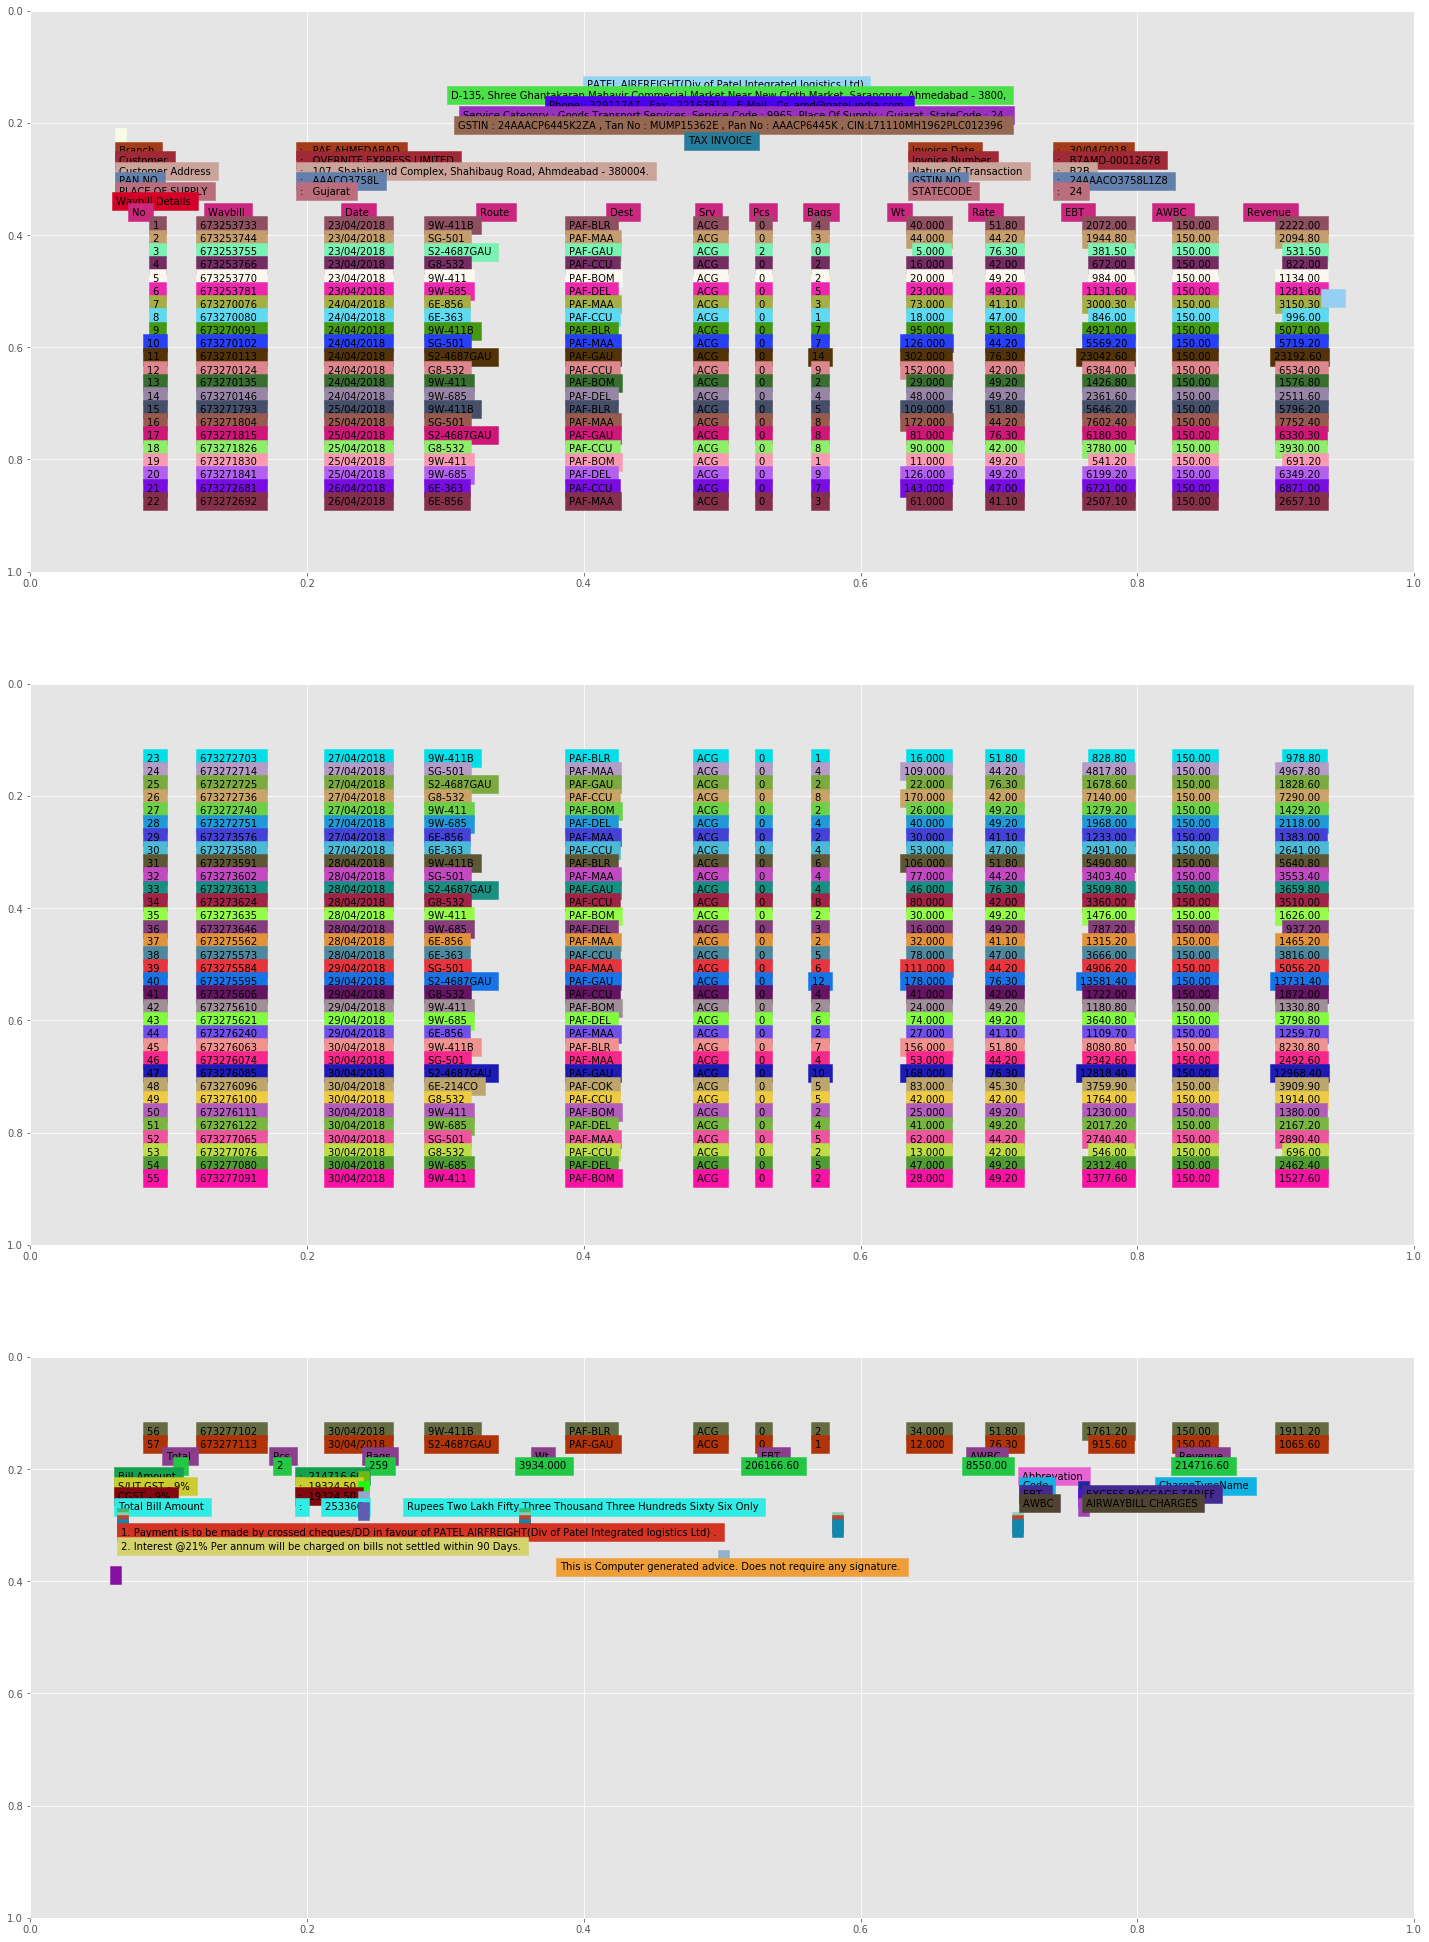

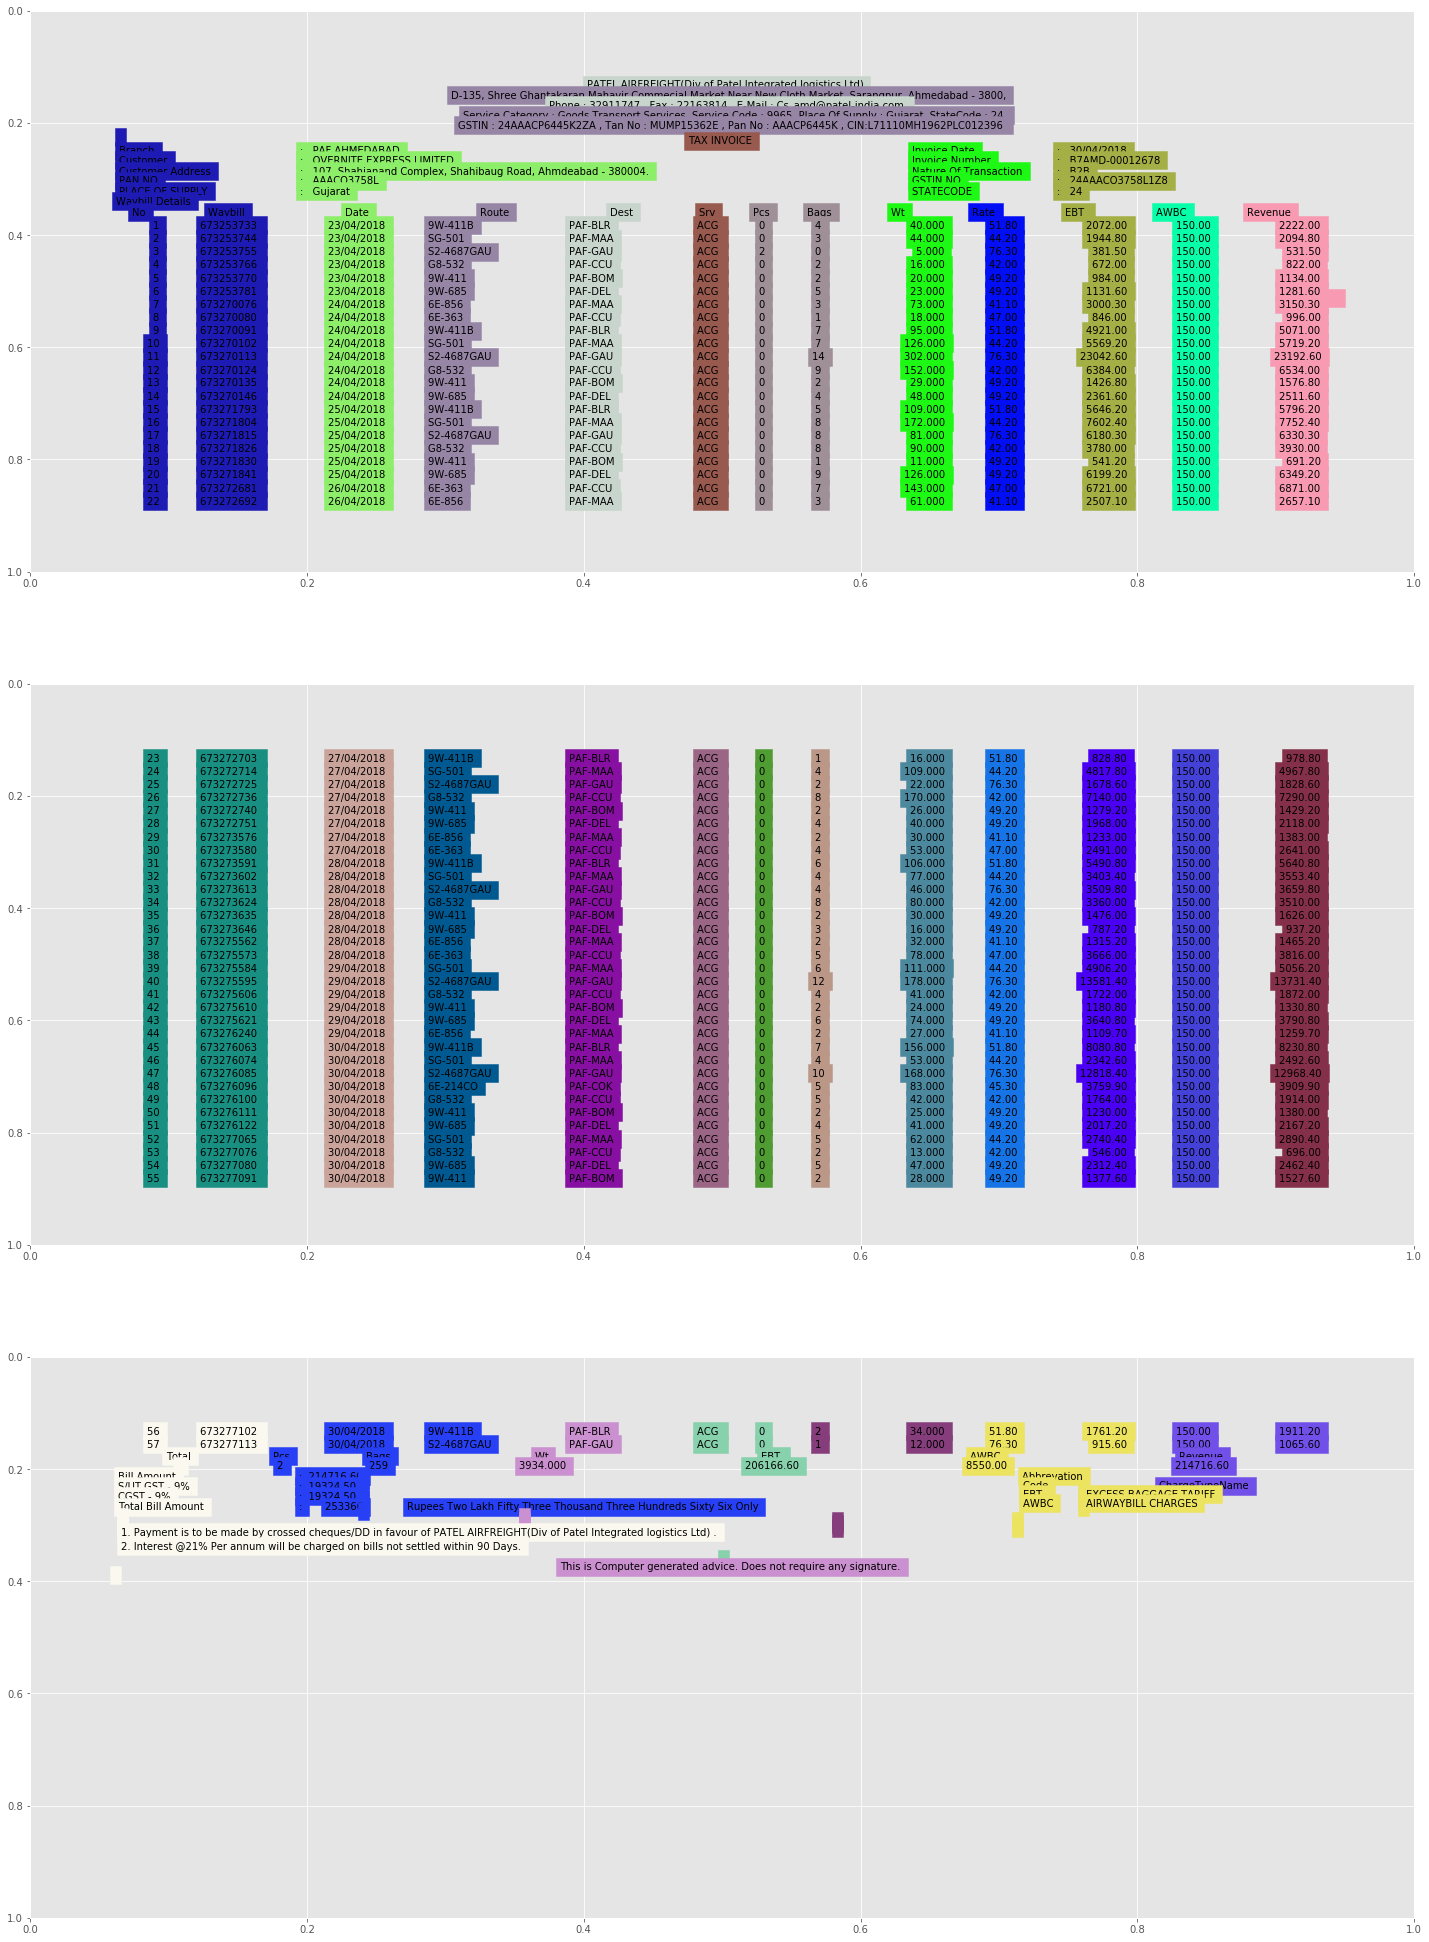

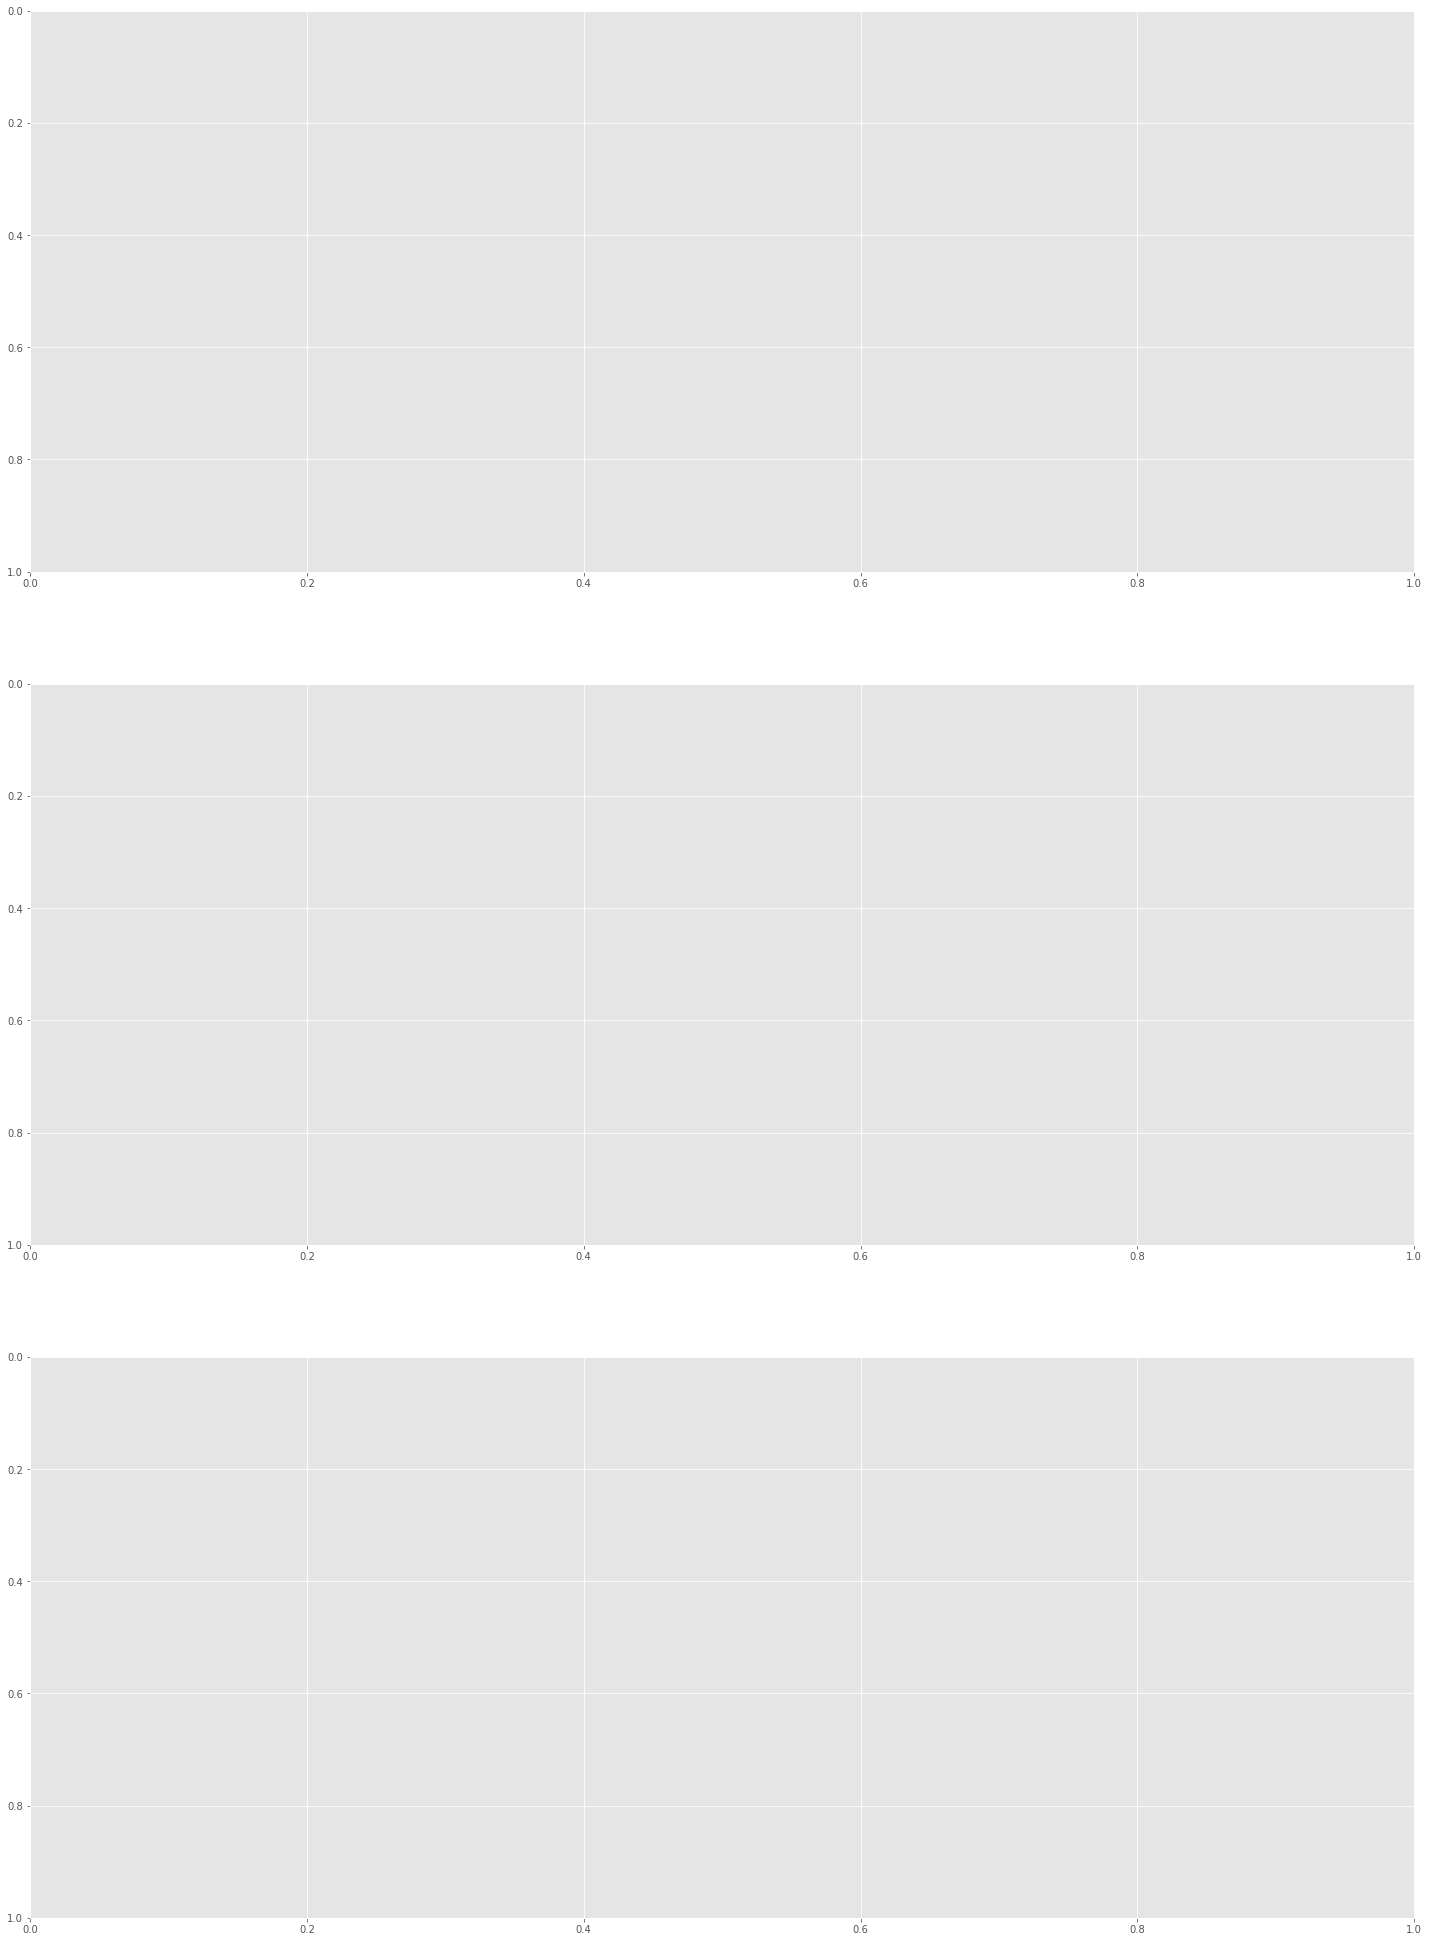

In [7]:
input_file = 'assets/request_history/5a57b416-6c6d-4738-88e9-1d69605b96de/invoicefiles/B7AMD-00012678.pdf'
invoice_date_field = {'id': 'INVOICE_DATE', 
 'page_no': 1,
 'key': 'INVOICE DATE',
 'bounding_box': [0.65517241379310343, 0.20783460282916214, 0.71152228763666947, 0.22524483133841131]}
search_fields = [invoice_date_field,]
extract_data(input_file, search_fields, debug=True)

In [8]:
input_file = 'assets/request_history/5a57b416-6c6d-4738-88e9-1d69605b96de/invoicefiles/B7AMD-00012678.pdf'
invoice_number_field = {'id': 'INVOICE_NUMBER', 
 'page_no': 1,
 'key': 'Invoice Number',
 'bounding_box': [0.65517241379310343, 0.17845484221980412, 0.70899915895710686, 0.19586507072905332]}
search_fields = [invoice_number_field,]
extract_data(input_file, search_fields)

{'INVOICE_NUMBER': []}

In [9]:
export_to_xlsx('assets/request_history/5a57b416-6c6d-4738-88e9-1d69605b96de/invoicefiles/B7AMD-00012678.pdf')


INVOICE_NUMBER => Not Matched
Accuracy = 0.0
Empty DataFrame
Columns: []
Index: [0]


In [10]:
extracted_df = pd.DataFrame(extracted)
extracted_df = extracted_df.dropna()
extracted_df

NameError: name 'extracted' is not defined

In [ ]:
writer = pd.ExcelWriter('invoice.xlsx')
extracted_df.to_excel(writer,'Sheet1')
writer.save()


In [22]:
extract_config = {
    'sample_file_name' : 'assets/request_history/5a57b416-6c6d-4738-88e9-1d69605b96de/invoicefiles/B7AMD-00012678.pdf',
    'search_fields': [
        { 'id': 'INVOICE_NUMBER', 'key': 'Invoice Number ', 'value': ':   B7AMD-00012678 '},
        { 'id': 'INVOICE_AMOUNT', 'key': 'Total Bill Amount', 'value': '253366 '},
        { 'id': 'INVOICE_DATE', 'key': 'Invoice Date ', 'value': ':   30/04/2018 '},
    ]
}

search_fields = get_search_fields(extract_config)

text_content : "PATEL AIRFREIGHT(Div of Patel Integrated logistics Ltd) "
text_content : "PATEL AIRFREIGHT(Div of Patel Integrated logistics Ltd) "
text_content : "PATEL AIRFREIGHT(Div of Patel Integrated logistics Ltd) "
text_content : "D-135, Shree Ghantakaran Mahavir Commecial Market,Near New Cloth Market, Sarangpur, Ahmedabad - 3800, "
text_content : "D-135, Shree Ghantakaran Mahavir Commecial Market,Near New Cloth Market, Sarangpur, Ahmedabad - 3800, "
text_content : "D-135, Shree Ghantakaran Mahavir Commecial Market,Near New Cloth Market, Sarangpur, Ahmedabad - 3800, "
text_content : "Phone : 32911747 , Fax : 22163814 , E-Mail : Cs_amd@patel-india.com, "
text_content : "Phone : 32911747 , Fax : 22163814 , E-Mail : Cs_amd@patel-india.com, "
text_content : "Phone : 32911747 , Fax : 22163814 , E-Mail : Cs_amd@patel-india.com, "
text_content : "Service Category : Goods Transport Services, Service Code : 9965, Place Of Supply : Gujarat, StateCode : 24  "
text_content : "Service Catego

text_content : "S2-4687GAU "
text_content : "S2-4687GAU "
text_content : "S2-4687GAU "
text_content : "PAF-GAU "
text_content : "PAF-GAU "
text_content : "PAF-GAU "
text_content : "ACG  "
text_content : "ACG  "
text_content : "ACG  "
text_content : "0 "
text_content : "0 "
text_content : "0 "
text_content : "4 "
text_content : "4 "
text_content : "4 "
text_content : "46.000 "
text_content : "46.000 "
text_content : "46.000 "
text_content : "76.30 "
text_content : "76.30 "
text_content : "76.30 "
text_content : "3509.80 "
text_content : "3509.80 "
text_content : "3509.80 "
text_content : "150.00 "
text_content : "150.00 "
text_content : "150.00 "
text_content : "3659.80 "
text_content : "3659.80 "
text_content : "3659.80 "
text_content : "34 "
text_content : "34 "
text_content : "34 "
text_content : "673273624  "
text_content : "673273624  "
text_content : "673273624  "
text_content : "28/04/2018 "
text_content : "28/04/2018 "
text_content : "28/04/2018 "
text_content : "G8-532 "
text_c

{'INVOICE_AMOUNT': [{'bounding_box': [0.1942889137737962,
    0.2723673792557403,
    0.19820828667413215,
    0.2842438638163104],
   'page_no': 3,
   'text': ': '},
  {'bounding_box': [0.21332586786114222,
    0.2723673792557403,
    0.24076147816349383,
    0.2842438638163104],
   'page_no': 3,
   'text': '253366 '},
  {'bounding_box': [0.2721164613661814,
    0.2723673792557403,
    0.5162374020156775,
    0.2842438638163104],
   'page_no': 3,
   'text': 'Rupees Two Lakh Fifty Three Thousand Three Hundreds Sixty Six Only '}],
 'INVOICE_DATE': [{'bounding_box': [0.7418812989921613,
    0.25494853523357086,
    0.7950727883538634,
    0.2668250197941409],
   'page_no': 1,
   'text': ':   30/04/2018 '}],
 'INVOICE_NUMBER': [{'bounding_box': [0.7418812989921613,
    0.2723673792557403,
    0.816909294512878,
    0.2842438638163104],
   'page_no': 1,
   'text': ':   B7AMD-00012678 '}]}

In [23]:
export_to_xlsx('assets/request_history/5a57b416-6c6d-4738-88e9-1d69605b96de/invoicefiles/*.pdf')

INVOICE_DATE => :   30/04/2018 
INVOICE_NUMBER => :   B7AMD-00012678 
INVOICE_AMOUNT => : 
INVOICE_AMOUNT => 253366 
INVOICE_AMOUNT => Rupees Two Lakh Fifty Three Thousand Three Hundreds Sixty Six Only 
INVOICE_DATE => :   22/04/2018 
INVOICE_NUMBER => :   B7BOM-00024690 
INVOICE_AMOUNT => 19/04/2018 
INVOICE_AMOUNT => 9W479 
INVOICE_DATE => Not Matched
INVOICE_NUMBER => :  B7BOM-00024716 
INVOICE_AMOUNT => 26/04/2018 
INVOICE_AMOUNT => SG421 
INVOICE_DATE => Invoice Date 
INVOICE_DATE => :  22/04/2018 
INVOICE_NUMBER => Invoice Number 
INVOICE_NUMBER => :  B7DEL-00019399 
INVOICE_AMOUNT => Not Matched
INVOICE_DATE => Invoice Date 
INVOICE_DATE => :  30/04/2018 
INVOICE_NUMBER => Invoice Number 
INVOICE_NUMBER => :  B7DEL-00019413 
INVOICE_AMOUNT => 70717323 
INVOICE_AMOUNT => PNQ 


'NoneType' object is not subscriptable
Traceback (most recent call last):
  File "<ipython-input-20-1f0c9dce7104>", line 203, in extract_data
    width = page['width']
TypeError: 'NoneType' object is not subscriptable


INVOICE_DATE => :   22/04/2018 
INVOICE_NUMBER => :   B7MAA-00023958 
INVOICE_AMOUNT => 21/04/2018 
INVOICE_DATE => Invoice Date 
INVOICE_DATE => :   30/04/2018 
INVOICE_NUMBER => Invoice Number 
INVOICE_NUMBER => :   B7MAA-00024031 
INVOICE_AMOUNT => 27/04/2018 
INVOICE_AMOUNT => SG612 
Accuracy = 0.9090909090909091
                                      INVOICE_AMOUNT     INVOICE_DATE  \
0  Rupees Two Lakh Fifty Three Thousand Three Hun...  :   30/04/2018    
1                                             9W479   :   22/04/2018    
4                                               PNQ    :  30/04/2018    
5                                        21/04/2018   :   22/04/2018    
6                                             SG612   :   30/04/2018    

        INVOICE_NUMBER  
0  :   B7AMD-00012678   
1  :   B7BOM-00024690   
4   :  B7DEL-00019413   
5  :   B7MAA-00023958   
6  :   B7MAA-00024031   


In [24]:
print(extracted_df)

NameError: name 'extracted_df' is not defined

In [585]:
extracted_df = pd.DataFrame(extracted)
extracted_df

,INVOICE_AMOUNT,INVOICE_DATE,INVOICE_NUMBER
0,₹ 7785.00,17-05-2018,Invoice Number 1805104044HCTRH
1,₹ 6133.00,17-05-2018,Invoice Number 1805104077HCTRH
2,₹ 461.00,17-05-2018,Invoice Number 1805104078HCTRB
3,₹ 1130.00,17-05-2018,Invoice Number 1805104079HCTRT
4,₹ 1101.00,17-05-2018,Invoice Number 1805104080HCTRT
5,₹ 1101.00,17-05-2018,Invoice Number 1805104081HCTRT
6,₹ 1003.00,17-05-2018,Invoice Number 1805104083HCTRT
7,₹ 1003.00,17-05-2018,Invoice Number 1805104084HCTRT
8,₹ 4659.00,17-05-2018,Invoice Number 1805104086HCTRH
9,₹ 4813.00,17-05-2018,Invoice Number 1805104087HCTRH


In [26]:
def preprocess_pdf_files(file_name_glob):
    """
    Export pdf file to xml, txt, image
    """
    invoice_files_names = glob.glob(file_name_glob)

    for pdf_file_path in invoice_files_names:
         
        # Extract the name pdf file from file_path
        pdf_file_name = os.path.basename(pdf_file_path)
        logger.debug('pdf_file_name : {}'.format(pdf_file_name))
        
        
        # Create temporary output directory
        output_directory_name = os.path.splitext(pdf_file_name)[0]
        logger.debug('output_directory_name : {}'.format(output_directory_name))
        
        output_path = os.path.join(OUTPUT_DIR, output_directory_name)
        logger.debug('output_path : {}'.format(output_path))
        
        os.makedirs(output_path, exist_ok=True)
        
        
        output_xml_file_path = os.path.join(output_path, pdf_file_name+'.xml')
        output_txt_file_path = os.path.join(output_path, pdf_file_name+'.txt')
        output_image_file_path = os.path.join(output_path, pdf_file_name+'')
        
        logger.debug('output_xml_file_path : {}'.format(output_xml_file_path))
        logger.debug('output_txt_file_path : {}'.format(output_txt_file_path))
        
        # Convert PDF to HTML using poppler
        run(['pdftohtml', pdf_file_path, '-c', '-hidden', '-xml', '-s', '-nomerge', output_xml_file_path])

        # Convert PDF to Text using poppler
        run(['pdftotext', pdf_file_path, output_txt_file_path])
        
        # Convert PDF to Image using poppler
        run(['pdftoppm', '-rx', '150', '-ry', '150', '-tiff', pdf_file_path, output_image_file_path])

In [27]:
preprocess_pdf_files('assets/request_history/*/invoicefiles/*.pdf')

OSError: [Errno 28] No space left on device: 'temp/7856'